# **第7章 商品推薦のための興味のスコアリング**

### **7.3 データ分析**

### ①本節の目的

与えられたデータ(access_log.csv)からユーザーが以下の二つを満たしていることを検証する. 
- **Recency に関する単調性** : ユーザーは最近閲覧した商品ほど興味がある
- **Frequency に関する単調性** : ユーザーは何度も閲覧した商品ほど興味がある

例えば, 以下のように「商品がいつ, 何回閲覧されたか」を示すデータがあると, 8/1〜8/3の閲覧履歴をもとに, 8/4の再閲覧率を推定できる. 
| 商品\日付 | 8/1 | 8/2 | 8/3 | 8/4 |
| -------- | --- | --- | --- | --- |
| item1 | 1 | 3 | 2 | 1 |
| item2 |  | 2 |  |  |
| item3 |  |  | 2 | 1 |
| item4 |  |  | 1 |  |

閲覧履歴をもとに, 基準日での再閲覧率を推定するために必要な情報
- **user_id** : ユーザーID
- **item_id** : 商品ID
- **freq** : ユーザーが商品を閲覧した総数
- **rcen** : ユーザーが最後に商品を見た日から基準日までの経過日数
- **pv_flag** : 再閲覧フラグ(基準日に閲覧していたら1, いなかったら0)

### ②データの概要

In [70]:
import pandas as pd

# access_log.csvより閲覧履歴を取り込む
log_df = pd.read_csv('access_log.csv', parse_dates=['date'])
print(len(log_df))
log_df.head()

325908


,user_id,item_id,date
0,4,205587,2015-07-04
1,4,748683,2015-07-04
2,4,790055,2015-07-04
3,4,790055,2015-07-04
4,4,764638,2015-07-04


In [71]:
# ユーザーID(user_id)の統計値を確認する
log_df['user_id'].value_counts().describe()

count    31443.000000
mean        10.365042
std         16.023399
min          2.000000
25%          3.000000
50%          5.000000
75%         11.000000
max        632.000000
Name: count, dtype: float64

In [72]:
# 商品ID(item_id)の統計値を確認する
log_df['item_id'].value_counts().describe()

count    87611.000000
mean         3.719944
std          8.802572
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max        941.000000
Name: count, dtype: float64

In [73]:
# 閲覧日(date)の件数を確認する
log_df['date'].value_counts()

date
2015-07-03    45441
2015-07-02    45394
2015-07-01    44163
2015-07-04    43804
2015-07-08    39933
2015-07-05    39932
2015-07-07    33930
2015-07-06    33311
Name: count, dtype: int64

### **③ データの性質**

In [74]:
# 日付操作をするライブラリdatetimeを取り込む
import datetime

start_date = datetime.datetime(2015,7,1)
end_date = datetime.datetime(2015,7,7)
target_date = datetime.datetime(2015,7,8)
print(start_date, end_date, target_date) # 追記

2015-07-01 00:00:00 2015-07-07 00:00:00 2015-07-08 00:00:00


In [75]:
'''
datetimeの解説

日付や時間に関する基本的な操作ができる（日時の加算・減算、差分の計算、フォーマット変換など）
'''

# 標準ライブラリなのでインストールは不要
import datetime

# mock用の日付を設定
mock_date1 = datetime.datetime(2015, 7, 1)
mock_date2 = datetime.datetime(2015, 7, 7)

# 日付の差を計算（mock_date1 - mock_date2）
date_difference = mock_date1 - mock_date2
print("日付の差:", date_difference.days, "日")  # 出力はマイナスの値（順番に注意）

# 日付の加算（mock_date1に7日間を加算）
new_date = mock_date1 + datetime.timedelta(days=7)
print("7日後の日付:", new_date)


日付の差: -6 日
7日後の日付: 2015-07-08 00:00:00


In [76]:
# 7月1日〜7月7日までのデータを抽出する（基準日7月8日は入っていない）
x_df = log_df[(start_date <= log_df['date']) & (log_df['date'] <= end_date)]
print(len(x_df))
x_df.head(3)

285975


,user_id,item_id,date
0,4,205587,2015-07-04
1,4,748683,2015-07-04
2,4,790055,2015-07-04


In [77]:
# 基準日7月8日のデータを抽出する
y_df = log_df[log_df['date'] == target_date]
print(len(y_df))
y_df.head()

39933


,user_id,item_id,date
103,94,603852,2015-07-08
104,94,28600,2015-07-08
105,94,987320,2015-07-08
106,94,109924,2015-07-08
107,94,886214,2015-07-08


In [78]:
'''
ユーザーIDをキーとし, その値として商品IDをキーに持つ辞書を格納する. 
この商品IDごとの値は, ユーザーがその商品を閲覧した際の最新度(rcen)のリストである. 

- rcenのリストの最小値 : ユーザーがその商品を最近閲覧した日
- rcenのリストの長さ : ユーザーがその商品を何回閲覧したか
'''

# ユーザーIDと閲覧した商品IDに対して、最新度のリストを対応させる辞書を作成する（ただし、辞書の入れ子として作成）
U2I2Rcens = {}
for row in x_df.itertuples():
    # 最新度(経過日数)の算出：基準日 - 最新の閲覧日
    rcen = (target_date - row.date).days
    
    # 辞書に最新度を登録
    # setdefaultメソッド : 指定されたキーが辞書に存在しない場合のみデフォルト値を返す
    U2I2Rcens.setdefault(row.user_id, {})
    U2I2Rcens[row.user_id].setdefault(row.item_id, [])
    U2I2Rcens[row.user_id][row.item_id].append(rcen)

In [79]:
# ユーザーID=2497について、閲覧した商品に対する最新度のリストを確認する
U2I2Rcens[2497]

{400521: [4, 2, 2, 2, 1], 678277: [4], 687963: [2], 178138: [1]}

In [80]:
# ユーザーIDと商品IDに対応する最新度(rcen)と頻度(freq)のデータを作成する
Rows1 = []
for user_id, I2Rcens in U2I2Rcens.items():
    for item_id, Rcens in I2Rcens.items():
        freq = len(Rcens)
        rcen = min(Rcens)
        Rows1.append((user_id, item_id, rcen, freq))
UI2RF_df = pd.DataFrame(Rows1, columns=['user_id', 'item_id', 'rcen', 'freq'])
print(len(UI2RF_df))
UI2RF_df.head()

204661


,user_id,item_id,rcen,freq
0,4,205587,4,1
1,4,748683,4,1
2,4,790055,4,3
3,4,764638,4,2
4,4,492434,4,1


In [81]:
# 閲覧フラグ(pv_flag)の作成
# drop_duplicatesメソッド : データフレーム内の重複した行を削除する
y_df = y_df.drop_duplicates()
print(len(y_df))
y_df['pv_flag'] = 1
y_df.head()

29651


,user_id,item_id,date,pv_flag
103,94,603852,2015-07-08,1
104,94,28600,2015-07-08,1
105,94,987320,2015-07-08,1
106,94,109924,2015-07-08,1
107,94,886214,2015-07-08,1


In [82]:
# 閲覧フラグ(pv_flag)の追加
UI2RFP_df = pd.merge(UI2RF_df, y_df[['user_id', 'item_id', 'pv_flag']], how='left', on=['user_id', 'item_id'])
UI2RFP_df['pv_flag'].fillna(0, inplace=True)
print(len(UI2RFP_df))
UI2RFP_df.head()

204661


,user_id,item_id,rcen,freq,pv_flag
0,4,205587,4,1,0.0
1,4,748683,4,1,0.0
2,4,790055,4,3,0.0
3,4,764638,4,2,0.0
4,4,492434,4,1,0.0


In [83]:
'''
pandas.mergeの解説

データフレームを結合（マージ）し、共通のキーを持つデータを一つのデータフレームにまとめることができる。

基本構文 : 
pd.merge(left, right, how='inner', on=None, left_on=None, right_on=None, suffixes=('_x', '_y'))

代表的な引数 : 
- left, right : 結合する2つのデータフレーム
- how : 結合方法を指定('inner' : 内部結合、'left' : 左結合、'right' : 右結合、'outer' : 外部結合)
- on : 結合するキー列を指定(leftとrightの両方に共通のキーが存在する場合)
- left_on, right_on : 左右のデータフレームで異なるキー列名を使用する場合に指定
- suffixes : 同じ列名がある場合のサフィックスを指定(デフォルトは('_x', '_y'))
'''

import pandas as pd

# mock用のデータを設定
data1 = {
    'user_id': [1, 2, 3],
    'item_id': [101, 102, 103],
    'rcen': [2, 5, 1],
    'freq': [3, 2, 1]
}
data2 = {
    'user_id': [1, 2, 4],
    'item_id': [101, 102, 104],
    'pv_flag': [1, 1, 1]
}

# データフレームを作成
mock_left_df = pd.DataFrame(data1)
mock_right_df = pd.DataFrame(data2)

# 左結合（left join）でマージ
mock_merge_df = pd.merge(mock_left_df, mock_right_df[['user_id', 'item_id', 'pv_flag']], how='left', on=['user_id', 'item_id'])

# 欠損値を0に置き換え
mock_merge_df['pv_flag'].fillna(0, inplace=True)

# マージ前とマージ後のデータフレームを表示
print("マージ前のデータフレーム (mock_left_df):")
print(mock_left_df)
print("\nマージ前のデータフレーム (mock_right_df):")
print(mock_right_df)
print("\nマージ後のデータフレーム (mock_merge_df):")
print(mock_merge_df)


マージ前のデータフレーム (mock_left_df):
   user_id  item_id  rcen  freq
0        1      101     2     3
1        2      102     5     2
2        3      103     1     1

マージ前のデータフレーム (mock_right_df):
   user_id  item_id  pv_flag
0        1      101        1
1        2      102        1
2        4      104        1

マージ後のデータフレーム (mock_merge_df):
   user_id  item_id  rcen  freq  pv_flag
0        1      101     2     3      1.0
1        2      102     5     2      1.0
2        3      103     1     1      0.0


In [84]:
# 最新度(rcen)と頻度(freq)の取りうる範囲を確認
print(sorted(UI2RFP_df['rcen'].unique()))
print(sorted(UI2RFP_df['freq'].unique()))

[1, 2, 3, 4, 5, 6, 7]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 31, 32, 34, 35, 41, 43, 58, 63, 118]


In [85]:
# 頻度(freq)が7以下になるようにデータを抽出(本書の都合でrcenと規模感を合わせるため)
tar_df = UI2RFP_df[UI2RFP_df['freq'] <= 7]
print(len(tar_df))
tar_df.head()

203456


,user_id,item_id,rcen,freq,pv_flag
0,4,205587,4,1,0.0
1,4,748683,4,1,0.0
2,4,790055,4,3,0.0
3,4,764638,4,2,0.0
4,4,492434,4,1,0.0


In [86]:
# 閲覧フラグ(pv_flag)の規模感の確認
tar_df['pv_flag'].sum()

2038.0

In [87]:
# 最新度(recency)に関する閲覧数の集計
rcen_df = pd.crosstab(index=tar_df['rcen'], columns=tar_df['pv_flag'])
rcen_df = rcen_df.rename(columns = {0:'neg', 1:'pos'})
rcen_df

pv_flag,neg,pos
rcen,,
1,24595,571
2,24032,274
3,28212,326
4,30641,275
5,31510,225
6,31721,199
7,30707,168


pv_flag,neg,pos,N,prob
rcen,,,,
1,24595,571,25166,0.022689
2,24032,274,24306,0.011273
3,28212,326,28538,0.011423
4,30641,275,30916,0.008895
5,31510,225,31735,0.007090
6,31721,199,31920,0.006234
7,30707,168,30875,0.005441


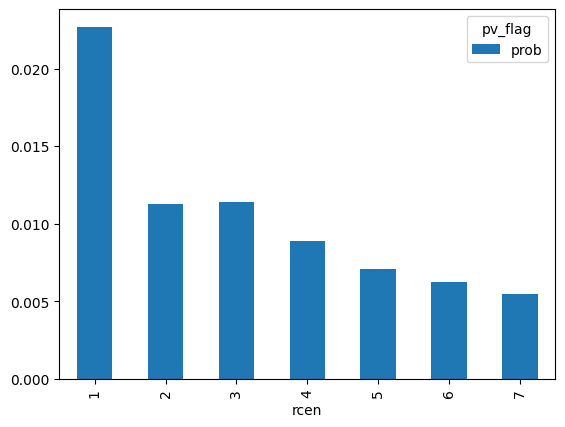

In [88]:
# 最新度(recency)に関する再閲覧確率の算出と確認
rcen_df['N'] = rcen_df['neg'] + rcen_df['pos']
rcen_df['prob'] = rcen_df['pos'] / rcen_df['N']
rcen_df[['prob']].plot.bar()
rcen_df

In [89]:
# 頻度(frequency)に関する閲覧数の集計
freq_df = pd.crosstab(index=tar_df['freq'], columns=tar_df['pv_flag'])
freq_df = freq_df.rename(columns = {0:'neg', 1:'pos'})
freq_df

pv_flag,neg,pos
freq,,
1,161753,964
2,24938,476
3,7733,258
4,3527,149
5,1807,88
6,1038,63
7,622,40


pv_flag,neg,pos,N,prob
freq,,,,
1,161753,964,162717,0.005924
2,24938,476,25414,0.018730
3,7733,258,7991,0.032286
4,3527,149,3676,0.040533
5,1807,88,1895,0.046438
6,1038,63,1101,0.057221
7,622,40,662,0.060423


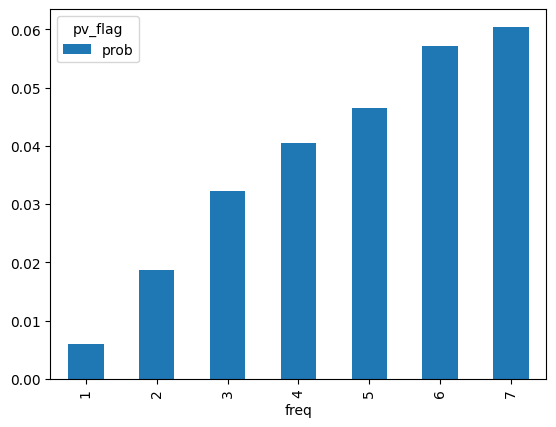

In [90]:
# 頻度(frequency)に関する再閲覧確率の算出と確認
freq_df['N'] = freq_df['neg'] + freq_df['pos']
freq_df['prob'] = freq_df['pos'] / freq_df['N']
freq_df[['prob']].plot.bar()
freq_df